## Read data

In [16]:
!python --version

Python 3.11.1


In [15]:
!sudo update-alternatives --list python3

/usr/bin/python3.11
/usr/bin/python3.8


In [ ]:
# Update python to 3.10
!sudo apt-get update -y
!sudo apt-get install python3.10

In [14]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1

update-alternatives: using /usr/bin/python3.11 to provide /usr/bin/python3 (python3) in auto mode


In [ ]:
# install pip for new python 
!sudo apt-get install python3.11-distutils
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py

# install colab's dependencies
!python -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.8/dist-packages/google \
       /usr/local/lib/python3.11/dist-packages/google

# restart Runtime

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pathlib import Path
import requests
data_path = Path('names.txt')
if not data_path.exists():
    r = requests.get('https://raw.githubusercontent.com/vladsavelyev/deeplearning/master/karpathy/names.txt')
    with data_path.open('wb') as f:
        f.write(r.content)

with data_path.open() as f:
    words = f.read().split()

print(words[:10])
print(len(words), max(len(w) for w in words), min(len(w) for w in words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033 15 2


In [3]:
alphabet = ['.'] + sorted(list(set(''.join(words))))
itos = {k: v for k, v in enumerate(alphabet)}
stoi = {v: k for k, v in itos.items()}

In [18]:
# Building our input examples. They should be a list of blocks of size 3,
# each containing 3 consecutive characters that can appear in a word (for
# character in the beginning of a word, we lead them with dots).
BLOCK_SIZE = 3  # context len: how many chars we take to predict next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
        X.append(context)
        Y.append(stoi[ch])
        # print(f'{"".join(map(itos.get, X[-1]))} ---> {itos[Y[-1]]}')
        context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype, X, Y)

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64 tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]]) tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [4]:
BLOCK_SIZE = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
training_threshold = int(len(words) * 0.8)
dev_threshold = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:training_threshold])
Xdev, Ydev = build_dataset(words[training_threshold:dev_threshold])
Xtest, Ytest = build_dataset(words[dev_threshold:])
len(Xtr), len(Xdev), len(Xtest)

(182625, 22655, 22866)

In [ ]:
# The number of dimensions of a space where we will embed our 27 characters 
embedding_space_dims = 2  # cram a 27d character space into 2d
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
# C maps a character to its embedding. It's initialised with random numbers,
# and to be trained with back propagation
C = torch.randn((len(alphabet), embedding_space_dims))

Essentially, `C` is a weight matrix to a layer with inputs of one-hot vectors representing each word/character, but because multiplying one-hot vectors and a matrix is equivalent to indexing, we can do straight indexing on C with X instead of multiplying.

In [ ]:
Xenc = F.one_hot(X, num_classes=len(alphabet))
Xenc.shape, C.shape, (Xenc.float() @ C).shape

(torch.Size([16, 3, 27]), torch.Size([27, 2]), torch.Size([16, 3, 2]))

In [ ]:
(Xenc.float() @ C) == C[X]

tensor([[[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True]]])

In [ ]:
X.shape, C.shape, C[X].shape

(torch.Size([9, 3]), torch.Size([27, 2]), torch.Size([9, 3, 2]))

In [ ]:
X, C, C[X]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1]]),
 tensor([[ 1.7236, -0.2821],
         [ 0.0631, -0.2419],
         [-1.2596,  1.5359],
         [-0.1327,  0.1062],
         [-1.0412,  0.9397],
         [ 1.2367,  1.7228],
         [ 0.4806, -0.5283],
         [-0.2371, -0.9269],
         [-0.8212, -0.3903],
         [-0.9627,  0.0910],
         [-1.0000, -0.4059],
         [ 1.1856,  0.8903],
         [-0.4065,  0.1030],
         [ 0.1481,  0.0815],
         [-0.4610, -1.0725],
         [ 1.4894,  0.7772],
         [-0.0510,  0.3810],
         [ 0.9041, -0.5399],
         [-1.3010, -0.0116],
         [ 0.0423,  2.3501],
         [-0.2972, -1.4968],
         [-0.4194, -0.5924],
         [ 0.8091,  0.7449],
         [-0.2217,  1.0166],
         [ 1.5464,  1.3728],
         [-0.2928,  0.1184],
         [ 2.1267, -0.1143]]),
 tenso

In [ ]:
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

In [ ]:
emb = emb.view(-1, embedding_space_dims * block_size)
emb.shape

torch.Size([16, 6])

In [ ]:
n_hidden_layers = 100
W1 = torch.randn((emb.shape[-1], n_hidden_layers), generator=g, requires_grad=True)
b1 = torch.randn(n_hidden_layers)

In [ ]:
h = torch.tanh(emb @ W1 + b1)
h.shape

torch.Size([16, 100])

In [ ]:
(emb @ W1).shape, b1.shape

(torch.Size([9, 100]), torch.Size([100]))

In [ ]:
W2 = torch.randn((n_hidden_layers, len(alphabet)))
b2 = torch.randn(len(alphabet))
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [ ]:
logits = h @ W2 + b2
pseudo_counts = logits.exp()
probs = pseudo_counts / pseudo_counts.sum(dim=1, keepdims=True)
probs.shape

torch.Size([16, 27])

In [ ]:
# Evaluate
print(probs.shape, Y.shape)
-probs[torch.arange(len(Y)), Y].log().mean()

torch.Size([16, 27]) torch.Size([16])


tensor(13.3399, grad_fn=<NegBackward0>)

In [ ]:
F.cross_entropy(logits, Y)

tensor(13.3399, grad_fn=<NllLossBackward0>)

In [ ]:
# Exploring space of learning rates to figure out the best
N_HIDDEN_LAYERS = 100
N_EPOCHS = 10
LEARNING_RATE = 0.1
MINIBATCH_SIZE = 30
N_BATCHES = 50

learning_rates = []
losses = []

for lri, lr in enumerate(10 ** torch.linspace(start=-3, end=0, steps=50)):
    print(f'{lri}: using learning rate {lr}')
    # Build NN
    C = torch.randn((len(alphabet), embedding_space_dims), generator=g)
    W1 = torch.randn((embedding_space_dims * block_size, n_hidden_layers), generator=g)
    b1 = torch.randn(n_hidden_layers)
    W2 = torch.randn((n_hidden_layers, len(alphabet)), generator=g)
    b2 = torch.randn(len(alphabet), generator=g)
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    print('Total number of parameters:', sum(p.nelement() for p in parameters))
    
    # Training
    for epoch_num in range(N_EPOCHS):
        for batch_n in range(N_BATCHES):
            minibatch_ix = torch.randint(low=0, high=X.shape[0], size=(MINIBATCH_SIZE,))
            minibatch_X = X[minibatch_ix]
            minibatch_Y = Y[minibatch_ix]
            # forward pass
            emb = C[minibatch_X].view(-1, block_size * embedding_space_dims)
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, minibatch_Y)
            # backward pass
            for p in parameters:
                p.grad = None
            loss.backward()
            # parameter update
            for p in parameters:
                p.data -= lr * p.grad
        emb = C[X].view(-1, block_size * embedding_space_dims)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y)
        print(f'{epoch_num=}, {loss.item()=}')
    learning_rates.append(lr)
    losses.append(loss.item())
    

0: using learning rate 0.0010000000474974513
Total number of parameters: 3481
epoch_num=0, loss.item()=15.914081573486328
epoch_num=1, loss.item()=15.348106384277344
epoch_num=2, loss.item()=14.881742477416992
epoch_num=3, loss.item()=14.488142013549805
epoch_num=4, loss.item()=14.113728523254395
epoch_num=5, loss.item()=13.771121978759766
epoch_num=6, loss.item()=13.453021049499512
epoch_num=7, loss.item()=13.15144157409668
epoch_num=8, loss.item()=12.86324405670166
epoch_num=9, loss.item()=12.59704875946045
1: using learning rate 0.0011513953795656562
Total number of parameters: 3481
epoch_num=0, loss.item()=15.412423133850098
epoch_num=1, loss.item()=14.852651596069336
epoch_num=2, loss.item()=14.377753257751465
epoch_num=3, loss.item()=13.972811698913574
epoch_num=4, loss.item()=13.595370292663574
epoch_num=5, loss.item()=13.252347946166992
epoch_num=6, loss.item()=12.928985595703125
epoch_num=7, loss.item()=12.620987892150879
epoch_num=8, loss.item()=12.341463088989258
epoch_num=9

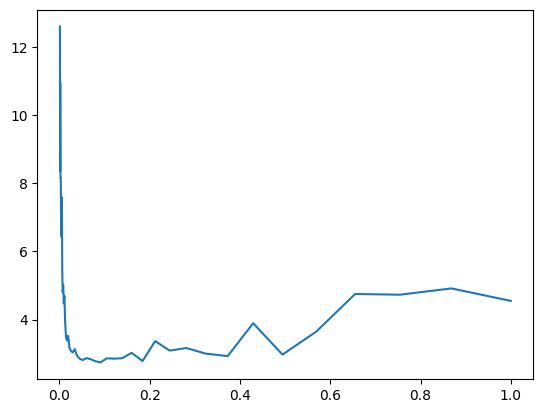

In [ ]:
plt.plot(lrs.detach(), [l.item() for l in losses])

Total number of parameters: 3481
0: using learning rate 0.0010000000474974513
1: using learning rate 0.001006938866339624
2: using learning rate 0.0010139254154637456
3: using learning rate 0.0010209609754383564
4: using learning rate 0.0010280447313562036
5: using learning rate 0.0010351781966164708
6: using learning rate 0.0010423606727272272
7: using learning rate 0.0010495934402570128
8: using learning rate 0.0010568759171292186
9: using learning rate 0.0010642095003277063
10: using learning rate 0.0010715933749452233
11: using learning rate 0.0010790290543809533
12: using learning rate 0.0010865157237276435
13: using learning rate 0.0010940548963844776
14: using learning rate 0.0011016458738595247
15: using learning rate 0.0011092900531366467
16: using learning rate 0.0011169867357239127
17: using learning rate 0.0011247374350205064
18: using learning rate 0.0011325412197038531
19: using learning rate 0.0011403998360037804
20: using learning rate 0.0011483123525977135
21: using le

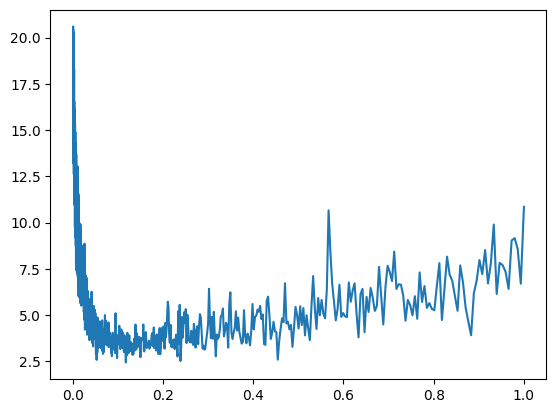

In [ ]:
N_HIDDEN_LAYERS = 100
LEARNING_RATE = 0.1
MINIBATCH_SIZE = 30

# Build NN
C = torch.randn((len(alphabet), embedding_space_dims), generator=g)
W1 = torch.randn((embedding_space_dims * block_size, n_hidden_layers), generator=g)
b1 = torch.randn(n_hidden_layers)
W2 = torch.randn((n_hidden_layers, len(alphabet)), generator=g)
b2 = torch.randn(len(alphabet), generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print('Total number of parameters:', sum(p.nelement() for p in parameters))

learning_rates = []
losses = []

for lri, lr in enumerate(10 ** torch.linspace(start=-3, end=0, steps=1000)):
    print(f'{lri}: using learning rate {lr}') 
    # Training
    minibatch_ix = torch.randint(low=0, high=X.shape[0], size=(MINIBATCH_SIZE,))
    minibatch_X = X[minibatch_ix]
    minibatch_Y = Y[minibatch_ix]
    # forward pass
    emb = C[minibatch_X].view(-1, block_size * embedding_space_dims)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, minibatch_Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # parameter update
    for p in parameters:
        p.data -= lr * p.grad

    learning_rates.append(lr)
    losses.append(loss.item())    
    
plt.plot(learning_rates, losses)

Total number of parameters: 3481
lr=0.1, epoch_n=49, calc_loss(Xdev, Ydev)=2.511946678161621, updating LR to 0.01
lr=0.01, epoch_n=49, calc_loss(Xdev, Ydev)=2.3862814903259277, updating LR to 0.001
lr=0.001, epoch_n=49, calc_loss(Xdev, Ydev)=2.375953435897827, updating LR to 0.0001
lr=0.0001, epoch_n=49, calc_loss(Xdev, Ydev)=2.374741554260254, updating LR to 1e-05
lr=1e-05, epoch_n=49, calc_loss(Xdev, Ydev)=2.3747074604034424, updating LR to 1.0000000000000002e-06
Final loss, dev: 2.3747074604034424
Final loss, test: 2.3805558681488037


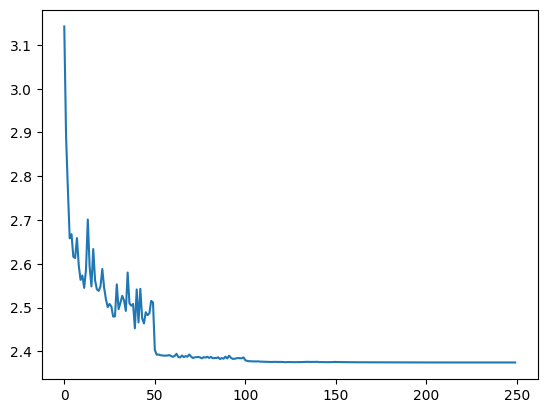

In [ ]:
N_HIDDEN_LAYERS = 100
LEARNING_RATE = 0.1
MINIBATCH_SIZE = 30

# Build NN
C = torch.randn((len(alphabet), embedding_space_dims), generator=g)
W1 = torch.randn((embedding_space_dims * block_size, n_hidden_layers), generator=g)
b1 = torch.randn(n_hidden_layers)
W2 = torch.randn((n_hidden_layers, len(alphabet)), generator=g)
b2 = torch.randn(len(alphabet), generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print('Total number of parameters:', sum(p.nelement() for p in parameters))

def calc_loss(X, Y):
    emb = C[X].view(-1, block_size * embedding_space_dims)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# Training
epochs = []
losses = []
lr = LEARNING_RATE
for lr_num in range(5):
    for epoch_n in range(50):
        for mb_num in range(200):
            ix = torch.randint(low=0, high=Xtr.shape[0], size=(MINIBATCH_SIZE,))

            # forward pass
            emb = C[Xtr[ix]].view(-1, block_size * embedding_space_dims)
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Ytr[ix])
        
            # backward pass
            for p in parameters:
                p.grad = None
            loss.backward()
        
            # parameter update
            for p in parameters:
                p.data -= lr * p.grad

        epochs.append(lr_num * 50 + epoch_n)
        losses.append(calc_loss(Xdev, Ydev))

    print(f'{lr=}, {epoch_n=}, {calc_loss(Xdev, Ydev)=}, ', end='')
    lr /= 10
    print(f'updating LR to {lr}')

print(f'Final loss, dev: {calc_loss(Xdev, Ydev)}')
print(f'Final loss, test: {calc_loss(Xtest, Ytest)}')

plt.plot(epochs, losses)

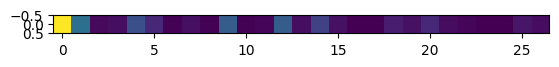

In [ ]:
x = torch.tensor(list(map(stoi.get, ['s', 'o', 'n'])))
emb = C[x].view(-1, embedding_space_dims * block_size)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
plt.imshow(probs.detach())
# next_char = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
# print(itos[next_char])

In [5]:
def generate_words(n_words=20):
    g = torch.Generator().manual_seed(42)
    max_word_len = 20
    for _ in range(n_words):
        context = [0] * BLOCK_SIZE
        losses = []
        for _ in range(max_word_len):
            x = torch.tensor(context[-BLOCK_SIZE:]).view(1, BLOCK_SIZE)
            emb = C[x].view(-1, EMB_SPACE_DIMS * BLOCK_SIZE)
            h = torch.tanh(emb @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            next_char = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            context.append(next_char)
            losses.append(-probs[0, next_char].log().mean().item())
            if next_char == 0:
                break
        gen_chars = context[3:]
        gen_word = ''.join(map(itos.get, gen_chars))
        print(f'{gen_word:<{max_word_len}} {sum(losses) / len(losses):.2f}')

generate_words(10)

Increasing number of hidden layers


In [ ]:
N_HIDDEN_LAYERS = 100
LEARNING_RATE = 0.1
MINIBATCH_SIZE = 30

# Build NN
C = torch.randn((len(alphabet), embedding_space_dims), generator=g)
W1 = torch.randn((embedding_space_dims * block_size, N_HIDDEN_LAYERS), generator=g)
b1 = torch.randn(N_HIDDEN_LAYERS)
W2 = torch.randn((N_HIDDEN_LAYERS, len(alphabet)), generator=g)
b2 = torch.randn(len(alphabet), generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print('Total number of parameters:', sum(p.nelement() for p in parameters))

def calc_loss(X, Y):
    emb = C[X].view(-1, block_size * embedding_space_dims)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# Training
LR_UPDATES_NUM = 5
EPOCHS_NUM = 100
MINIBATCHES_NUM = 10000
losses = []  # all losses for stats
last_losses = []  # tracking last 10 losses to degrade learning rate
lr = LEARNING_RATE
min_lr = LEARNING_RATE / 10 ** LR_UPDATES_NUM
for epoch_i in range(EPOCHS_NUM):
    full_loss = calc_loss(Xdev, Ydev)
    losses.append(full_loss)
    last_losses.append(full_loss)
    print(f'{lr=}, {epoch_i=}, loss_dev={full_loss}')

    if len(last_losses) >= 5:
        loss_change = 1 - last_losses[-1] / last_losses[-5]
        print('Loss change:', loss_change)
        if loss_change < 0.01:
            # training saturated, need to decrease learning rate or early stop
            if lr > min_lr:
                print(f'Learning rate change is small: {loss_change}, updating', lr, ' -> ', end=' ')
                lr /= 10
                print(lr)
                last_losses = []
                print()
            else:
                print('Early stop')
                break

    for mb_i in range(MINIBATCHES_NUM):
        ix = torch.randint(low=0, high=Xtr.shape[0], size=(MINIBATCH_SIZE,))

        # forward pass
        emb = C[Xtr[ix]].view(-1, block_size * embedding_space_dims)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
    
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # parameter update
        for p in parameters:
            p.data -= lr * p.grad
    
print(f'Final loss, dev:  {calc_loss(Xdev, Ydev)}')
print(f'Final loss, test: {calc_loss(Xtest, Ytest)}')

Total number of parameters: 3481
lr=0.1, epoch_i=0, loss_dev=17.96455192565918
lr=0.1, epoch_i=1, loss_dev=2.476928472518921
lr=0.1, epoch_i=2, loss_dev=2.411865234375
lr=0.1, epoch_i=3, loss_dev=2.3951308727264404
lr=0.1, epoch_i=4, loss_dev=2.402864694595337
Loss change: 0.8662441064748589
lr=0.1, epoch_i=5, loss_dev=2.3892178535461426
Loss change: 0.03541104232355197
lr=0.1, epoch_i=6, loss_dev=2.3620870113372803
Loss change: 0.020638890734133053
lr=0.1, epoch_i=7, loss_dev=2.3308565616607666
Loss change: 0.02683540669846929
lr=0.1, epoch_i=8, loss_dev=2.3507630825042725
Loss change: 0.021683123568403295
lr=0.1, epoch_i=9, loss_dev=2.3355014324188232
Loss change: 0.022482847701640885
lr=0.1, epoch_i=10, loss_dev=2.3696110248565674
Loss change: -0.0031853244538300185
Learning rate change is small: -0.0031853244538300185, updating 0.1  ->  0.01

lr=0.01, epoch_i=11, loss_dev=2.2601840496063232
lr=0.01, epoch_i=12, loss_dev=2.2568359375
lr=0.01, epoch_i=13, loss_dev=2.2570254802703857


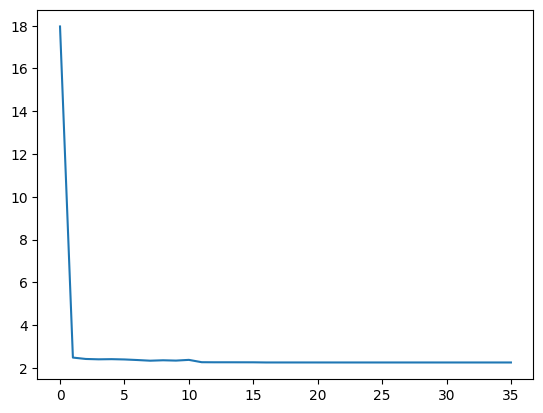

In [ ]:
plt.plot(range(len(losses)), losses)

In [ ]:
generate_words(10)

abb.                 2.59
keys.                2.50
adershe.             2.05
mel.                 2.16
mak.                 2.09
aybe.                2.34
daijelv.             2.66
emrah.               2.08
zomarina.            1.91
lez.                 2.46


In [ ]:
C.shape

torch.Size([27, 2])

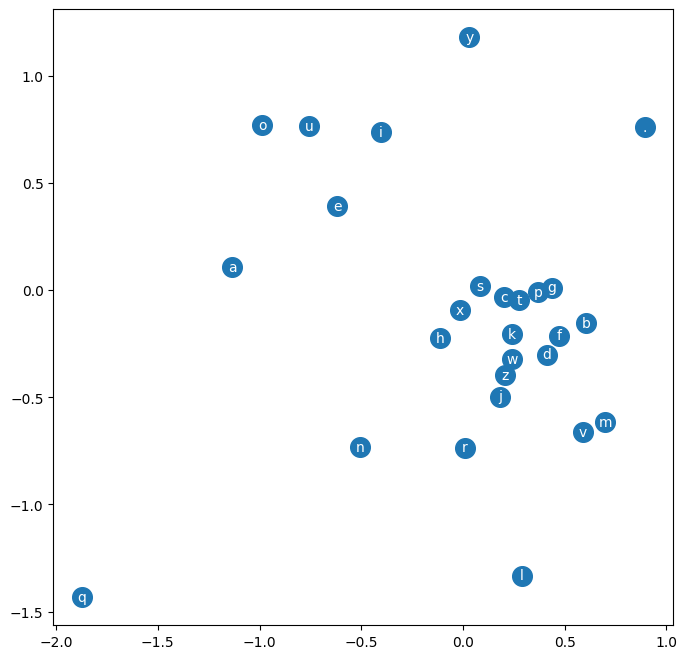

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')


Increasing the embedding space dimentionality

In [11]:
# Build NN
N_HIDDEN_LAYERS = 100
LEARNING_RATE = 0.1
MINIBATCH_SIZE = 30
# The number of dimensions of a space where we will embed our 27 characters 
EMB_SPACE_DIMS = 10  # cram a 27d character space into 10d

g = torch.Generator().manual_seed(42)  # for reproducibility
# C maps a character to its embedding. It's initialised with random numbers,
# and to be trained with back propagation
C = torch.randn((len(alphabet), EMB_SPACE_DIMS), generator=g)
W1 = torch.randn((EMB_SPACE_DIMS * BLOCK_SIZE, N_HIDDEN_LAYERS), generator=g)
b1 = torch.randn(N_HIDDEN_LAYERS)
W2 = torch.randn((N_HIDDEN_LAYERS, len(alphabet)), generator=g)
b2 = torch.randn(len(alphabet), generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print('Total number of parameters:', sum(p.nelement() for p in parameters))

def calc_loss(X, Y):
    emb = C[X].view(-1, BLOCK_SIZE * EMB_SPACE_DIMS)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# Training
LR_UPDATES_NUM = 4
EPOCHS_NUM = 100
MINIBATCHES_NUM = 100_000  # to slow for a laptop, use Colab
losses = []  # all losses for stats
last_losses = []  # tracking last 10 losses to degrade learning rate
lr = LEARNING_RATE
lr_update_i = 0

print(f'Initial loss_dev={calc_loss(Xdev, Ydev)}')

for epoch_i in range(EPOCHS_NUM):
    for mb_i in range(MINIBATCHES_NUM):
        ix = torch.randint(low=0, high=Xtr.shape[0], size=(MINIBATCH_SIZE,))

        # forward pass
        emb = C[Xtr[ix]].view(-1, BLOCK_SIZE * EMB_SPACE_DIMS)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
    
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # parameter update
        for p in parameters:
            p.data -= lr * p.grad

    losses.append(calc_loss(Xdev, Ydev))
    last_losses.append(losses[-1])
    print(f'{lr=}, {epoch_i=}, loss_dev={losses[-1]}')

    if len(last_losses) >= 5:
        loss_change = 1 - last_losses[-1] / last_losses[-5]
        print('Loss change:', loss_change)
        if loss_change < 0.01:
            # training saturated, need to decrease learning rate or early stop
            if lr_update_i < LR_UPDATES_NUM:
                lr_update_i += 1
                print(f'Learning rate change is small: {loss_change}, updating', lr, ' -> ', end=' ')
                lr /= 10
                print(f'{lr}. This is update #{lr_update_i}')
                last_losses = []
                print()
            else:
                print('Early stop')
                break

print(f'Final loss, dev:  {calc_loss(Xdev, Ydev)}')
print(f'Final loss, test: {calc_loss(Xtest, Ytest)}')

Total number of parameters: 6097
lr=0.1, epoch_i=0, loss_dev=2.2484331130981445
lr=0.1, epoch_i=1, loss_dev=2.271027088165283
lr=0.1, epoch_i=2, loss_dev=2.22369647026062
lr=0.1, epoch_i=3, loss_dev=2.211862802505493
lr=0.1, epoch_i=4, loss_dev=2.214603900909424
Loss change: 0.015045683143363298
lr=0.1, epoch_i=5, loss_dev=2.2074618339538574
Loss change: 0.027989650384478204
lr=0.1, epoch_i=6, loss_dev=2.213111162185669
Loss change: 0.004760230641419616
Learning rate change is small: 0.004760230641419616, updating 0.1  ->  0.01. This is update #1

lr=0.01, epoch_i=7, loss_dev=2.138786554336548
lr=0.01, epoch_i=8, loss_dev=2.137395143508911
lr=0.01, epoch_i=9, loss_dev=2.139477252960205
lr=0.01, epoch_i=10, loss_dev=2.1398239135742188
lr=0.01, epoch_i=11, loss_dev=2.137305974960327
Loss change: 0.0006922520497516516
Learning rate change is small: 0.0006922520497516516, updating 0.01  ->  0.001. This is update #2

lr=0.001, epoch_i=12, loss_dev=2.130197286605835
lr=0.001, epoch_i=13, los

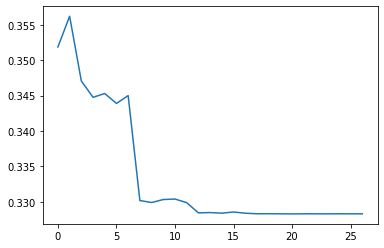

In [12]:
import math
plt.plot(range(len(losses)), [math.log10(l) for l in losses])

In [13]:
generate_words(15)

abbaleycah.          2.50
hosel.               2.22
mel.                 2.13
maka.                1.82
valaiel.             2.08
liv.                 2.74
ely.                 2.08
jazon.               2.02
meri.                1.92
lez.                 2.49
hel.                 2.32
nasherson.           1.86
yadi.                2.18
khalindaryan.        1.85
ayqauzami.           2.49


In [ ]:
generate_words(15)

abd.                 2.22
keys.                2.40
aderren.             1.96
melana.              1.75
aby.                 2.20
dalee.               1.62
liv.                 2.52
ely.                 2.09
jazya.               1.98
mere.                1.96
lez.                 2.55
hel.                 2.23
nashfiri.            2.27
kylak.               2.60
khalime.             1.96
